In [1]:
import requests

# Dummies

In [2]:
r = requests.get("http://127.0.0.1:2021/dummy_get")
r.json()

{'dummy': 'get'}

In [3]:
r = requests.post("http://127.0.0.1:2021/dummy_post", json={"foo": "bar"})
r.json()

{'received_body': {'foo': 'bar'}, 'dummy': 'post'}

In [4]:
r = requests.get("http://127.0.0.1:2021/get_available_models")
r.json()

['BR', 'ORd', 'Maleckar']

# Get model params

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
r = requests.post("http://127.0.0.1:2021/get_model_params",
                  json={"model_name": "BR"})

In [7]:
%%time
requests.post("http://127.0.0.1:2021/get_model_params",
              json={"model_name": "BR"})

CPU times: user 7.02 ms, sys: 0 ns, total: 7.02 ms
Wall time: 131 ms


<Response [200]>

In [8]:
params = pd.DataFrame(r.json()["params"]).set_index(["component", "variable"])
states = pd.DataFrame(r.json()["states"]).set_index(["component", "variable"])
observables = pd.DataFrame(r.json()["observables"]).set_index(["component", "variable"])

In [9]:
params.sort_index()

value
component           variable                       
membrane            C                       0.01000
slow_inward_current g_s                     0.00090
sodium_current      E_Na                   50.00000
                    g_Na                    0.04000
                    g_Nac                   0.00003
stimulus_protocol   IstimAmplitude          0.50000
                    IstimEnd            50000.00000
                    IstimPeriod          1000.00000
                    IstimPulseDuration      1.00000
                    IstimStart             10.00000

In [10]:
states.sort_index()

,,value
component,variable,
membrane,V,-84.6240
slow_inward_current,Cai,0.0001
slow_inward_current_d_gate,d,0.0030
slow_inward_current_f_gate,f,0.9940
sodium_current_h_gate,h,0.9880
sodium_current_j_gate,j,0.9750
sodium_current_m_gate,m,0.0110
time_dependent_outward_current_x1_gate,x1,0.0001


In [11]:
observables.sort_index()

value
component                              variable       
membrane                               Istim       0.0
                                       i_K1        0.0
                                       i_Na        0.0
                                       i_s         0.0
                                       i_x1        0.0
slow_inward_current                    E_s         0.0
                                       V           0.0
                                       d           0.0
                                       f           0.0
                                       i_s         0.0
slow_inward_current_d_gate             V           0.0
                                       alpha_d     0.0
                                       beta_d      0.0
slow_inward_current_f_gate             V           0.0
                                       alpha_f     0.0
                                       beta_f      0.0
sodium_current                         V           0.0
                                       h           0.0
                                       i_Na        0.0
                                       j           0.0
                                       m           0.0
sodium_current_h_gate                  V           0.0
                                       alpha_h     0.0
                                       beta_h      0.0
sodium_current_j_gate                  V           0.0
                                       alpha_j     0.0
                                       beta_j      0.0
sodium_current_m_gate                  V           0.0
                                       alpha_m     0.0
                                       beta_m      0.0
stimulus_protocol                      Istim       0.0
time_dependent_outward_current         V           0.0
                                       i_x1        0.0
                                       x1          0.0
time_dependent_outward_current_x1_gate V           0.0
                                       alpha_x1    0.0
                                       beta_x1     0.0
time_independent_outward_current       V           0.0
                                       i_K1        0.0

# Solve model

## kwargs

In [12]:
kwargs_problem_keys = ["u0", "p", "tspan"]

In [13]:
kwargs_output_keys = ["saveat", "tstops"]  # and other ...
kwargs_stepping_keys = ["abstol", "reltol", "dt", "dtmax", "dtmin"]  # and others ...
# kwargs_misc_keys = ["callback"]

kwargs_solve_keys = ["solver"] + kwargs_output_keys + kwargs_stepping_keys

## BR

In [14]:
params.loc[("stimulus_protocol", "IstimStart")] = 0.
params.loc[("sodium_current", "g_Na")] = 0.04 * 0.5
params.loc[("slow_inward_current", "g_s")] = 0.0009 * 1.5

params

value
component           variable                       
sodium_current      g_Na                    0.02000
                    E_Na                   50.00000
                    g_Nac                   0.00003
stimulus_protocol   IstimStart              0.00000
                    IstimEnd            50000.00000
                    IstimAmplitude          0.50000
                    IstimPeriod          1000.00000
                    IstimPulseDuration      1.00000
slow_inward_current g_s                     0.00135
membrane            C                       0.01000

In [15]:
req_dict = {"model_name": "BR",
            "kwargs_problem": {"p0": params["value"].to_list(), "tspan": [0, 2000]},
            "kwargs_solve": {"solver": "CVODE_BDF", "dt": 1e-5, "dtmax": 0.5}}
req_dict

{'model_name': 'BR',
 'kwargs_problem': {'p0': [0.02,
   50.0,
   3e-05,
   0.0,
   50000.0,
   0.5,
   1000.0,
   1.0,
   0.00135,
   0.01],
  'tspan': [0, 2000]},
 'kwargs_solve': {'solver': 'CVODE_BDF', 'dt': 1e-05, 'dtmax': 0.5}}

# Solve model

In [16]:
r = requests.post("http://127.0.0.1:2021/solve_problem", json=req_dict)

In [17]:
%%time
requests.post("http://127.0.0.1:2021/solve_problem", json=req_dict)

CPU times: user 3.55 ms, sys: 4.69 ms, total: 8.24 ms
Wall time: 2.4 s


<Response [200]>

In [18]:
response = r.json()

In [19]:
response.keys()

dict_keys(['time', 'observables'])

In [20]:
legend = response["observables"]["V"]["components"]

In [21]:
def create_obs_legend(response):
    data = [[c, k] for k, v in response["observables"].items() for c in v["components"]]
    columns = ["component", "variable"]
    df = pd.DataFrame(data, columns=["component", "variable"]).set_index(columns).sort_index()
    return df

In [22]:
create_obs_legend(response)

Empty DataFrame
Columns: []
Index: [(membrane, Istim), (membrane, i_K1), (membrane, i_Na), (membrane, i_s), (membrane, i_x1), (slow_inward_current, E_s), (slow_inward_current, V), (slow_inward_current, d), (slow_inward_current, f), (slow_inward_current, i_s), (slow_inward_current_d_gate, V), (slow_inward_current_d_gate, alpha_d), (slow_inward_current_d_gate, beta_d), (slow_inward_current_f_gate, V), (slow_inward_current_f_gate, alpha_f), (slow_inward_current_f_gate, beta_f), (sodium_current, V), (sodium_current, h), (sodium_current, i_Na), (sodium_current, j), (sodium_current, m), (sodium_current_h_gate, V), (sodium_current_h_gate, alpha_h), (sodium_current_h_gate, beta_h), (sodium_current_j_gate, V), (sodium_current_j_gate, alpha_j), (sodium_current_j_gate, beta_j), (sodium_current_m_gate, V), (sodium_current_m_gate, alpha_m), (sodium_current_m_gate, beta_m), (stimulus_protocol, Istim), (time_dependent_outward_current, V), (time_dependent_outward_current, i_x1), (time_dependent_outward_current, x1), (time_dependent_outward_current_x1_gate, V), (time_dependent_outward_current_x1_gate, alpha_x1), (time_dependent_outward_current_x1_gate, beta_x1), (time_independent_outward_current, V), (time_independent_outward_current, i_K1)]

In [23]:
def observables_to_dataframe(response):
    data = {k: v["value"] for k, v in response["observables"].items()}
    df = pd.DataFrame(data)
    return df

In [24]:
t = response["time"]
df = observables_to_dataframe(response)
df

,f,i_s,V,alpha_m,alpha_f,h,i_Na,beta_m,i_K1,E_s,...,alpha_j,beta_d,alpha_x1,beta_j,x1,alpha_h,m,alpha_d,beta_h,beta_f
0,0.994000,-0.000570,-84.624000,0.894710,0.018872,0.988000,-0.004046,81.111395,0.004594,127.697833,...,0.060509,0.123196,0.000025,0.001547,0.000100,0.847492,0.011000,0.000366,0.010362,3.489661e-07
1,0.994000,-0.000570,-84.624000,0.894710,0.018872,0.988000,-0.004046,81.111395,0.004594,127.697825,...,0.060509,0.123196,0.000025,0.001547,0.000100,0.847492,0.011000,0.000366,0.010362,3.489661e-07
2,0.994000,-0.000570,-84.623990,0.894710,0.018872,0.988000,-0.004046,81.111350,0.004594,127.694613,...,0.060508,0.123196,0.000025,0.001547,0.000100,0.847490,0.010976,0.000366,0.010362,3.489667e-07
3,0.994001,-0.000570,-84.623971,0.894712,0.018872,0.987999,-0.004046,81.111265,0.004594,127.688510,...,0.060508,0.123196,0.000025,0.001547,0.000100,0.847486,0.010945,0.000366,0.010362,3.489679e-07
4,0.994002,-0.000570,-84.623953,0.894713,0.018872,0.987999,-0.004045,81.111180,0.004594,127.682413,...,0.060508,0.123196,0.000025,0.001547,0.000101,0.847482,0.010927,0.000366,0.010362,3.489691e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4211,0.999980,-0.000556,-84.418781,0.908727,0.018841,0.987079,-0.004040,80.184575,0.004931,120.080340,...,0.059368,0.122622,0.000026,0.001579,0.022204,0.805108,0.011206,0.000371,0.010536,3.620975e-07
4212,0.999980,-0.000556,-84.419110,0.908705,0.018841,0.987080,-0.004040,80.186052,0.004931,120.080502,...,0.059370,0.122623,0.000026,0.001579,0.022168,0.805175,0.011205,0.000371,0.010536,3.620760e-07
4213,0.999980,-0.000556,-84.419438,0.908682,0.018841,0.987082,-0.004040,80.187527,0.004930,120.080663,...,0.059372,0.122624,0.000026,0.001579,0.022132,0.805241,0.011205,0.000371,0.010536,3.620546e-07
4214,0.999980,-0.000556,-84.419766,0.908660,0.018841,0.987083,-0.004040,80.188999,0.004930,120.080824,...,0.059374,0.122625,0.000026,0.001579,0.022096,0.805307,0.011205,0.000371,0.010535,3.620333e-07


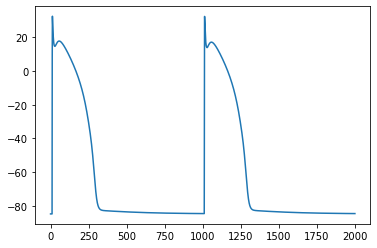

In [25]:
plt.plot(t, df["V"])

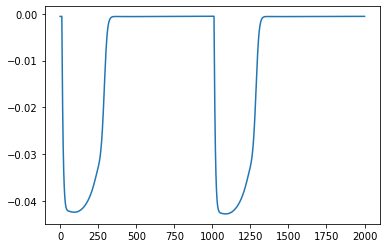

In [26]:
plt.plot(t, df["i_s"])